In [1]:
!pip install pytorch-pretrained-bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 536.2 kB/s eta 0:00:00


## Important Necessary Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore") 
import os
import numpy as np
import pickle
import tensorflow as tf
from nltk.corpus import stopwords
import string

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)
    print(n_gpu)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

1
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [3]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Preprocessing
### Sentiment

In [4]:
labels = list(df['sentiment'].apply(lambda x: 1 if x=='positive' else 0))

### Review
#### Clean the text HTML tag

In [5]:
#cleaning the text
from bs4 import BeautifulSoup
import re

def strip(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub('\[[^]]*\]', '', soup.get_text())
    pattern=r"[^a-zA-z0-9\s,']"
    text=re.sub(pattern,'',text)
    return text

df['review']=df['review'].apply(strip)

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming tech...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,Petter Mattei's Love in the Time of Money is a...,positive


BERT expects input data in a specific format
- 1. We are performing a classification task so we use a special token [CLS] to indicate this to BERT.
- 2. It needs to know the end of a sentence so we use the [SEP] token.

In [7]:
#BERT needs to understand 2 things:
#1) The start and end of each sentiment
# so we declare a special token CLS which tells BERT that its a classification task
sentences = df['review']
sentence = ["[CLS] "+i+" [SEP]" for i in sentences]

sentence[0]

"[CLS] One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked They are right, as this is exactly what happened with meThe first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO Trust me, this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs, sex or violence Its is hardcore, in the classic use of the wordIt is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda Em City is home to manyAryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and moreso scuffles, death stares, dodgy dealings and shady agreements are never far awayI would say the main appeal of the show is due to the fact that it goes where other shows wouldn't da

### Tokenization
We now need to tokenize our text into tokens that correspond to BERT’s vocabulary.

In [8]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 901514.48B/s]


In [9]:
%%time
Stopwords = set(stopwords.words("english"))
# Restricting the max size of Tokens to 512(BERT doest accept any more than this)
tokenized_texts = []
for text in sentence:
    Tokens = tokenizer.tokenize(text) # Restricting the max size of Tokens to 512(BERT doest accept any more than this)
    tokens = []
    for token in Tokens:
        if token not in Stopwords and not token.isdigit() and token not in string.punctuation:
            tokens.append(token)
          
    tokenized_texts.append(tokens)

CPU times: user 3min 37s, sys: 423 ms, total: 3min 37s
Wall time: 3min 38s


Here, first sentence tokenized_texts length is `365` if we consider the `MAX_LEN = 128` then we are not considering 2/3 part of the data. So. we remove the stopwords from sentence. Because that is not the influencial part for the sentiment being `positive` or `negative`

### Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary

In [10]:
%%time
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
text_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

CPU times: user 1.65 s, sys: 50 ms, total: 1.7 s
Wall time: 1.7 s


### Padding

In [11]:
# Set the maximum sequence length. 
MAX_LEN = 128

input_ids = pad_sequences(text_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

#### BERT is a MLM(Masked Language Model). We have to define its mask.

In [12]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

### Example

In [13]:
print ("Tokenized first sentence:")
print (tokenized_texts[0])
print ('Tokenized first sentence Length :',len(tokenized_texts[0]))
print()

print ("convert the tokens to their index numbers in the BERT vocabulary:")
print(tokenizer.convert_tokens_to_ids(tokenized_texts[0]))
print()

print ("Padding")
print('Before Padding, Length :',len(text_ids[0]))
print('After Padding, Length :',len(input_ids[0]))

print()
print('Mask',attention_masks[0])
print('Mask length :',len(attention_masks[0]))

Tokenized first sentence:
['[CLS]', 'one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'hooked', 'right', 'exactly', 'happened', 'met', '##he', 'first', 'thing', 'struck', 'oz', 'brutality', 'un', '##fl', '##in', '##ching', 'scenes', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'tim', '##id', 'show', 'pulls', 'punches', 'regards', 'drugs', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', '##it', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'pen', '##ite', '##nta', '##ry', 'focuses', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inward', '##s', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', '##ary', '##ans', 'muslims', 'gangs', '##tas', 'latino', '##s', 'christians', 'italians', 'irish', '##so', 'sc', '##uf', '##fles', 'death', 'stares', 'dod', '##gy', 'dealings', 'shady', 'agreements', 'never', 'far', 'away', '##i', 'would', 'say', 

#### Now we need to split the data into train and validation.

In [14]:
# Select a batch size for training. 
batch_size = 16

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, 
                                                                                    labels, 
                                                                                    random_state=2023, 
                                                                                    test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2023, 
                                                       test_size=0.1)

#### Convert all of our data into torch tensors, the required datatype for our model

In [15]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

#### Create an iterator of our data with torch DataLoader 

In [16]:
# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Load the model

In [17]:
#Loading pre trained BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)#binary classification
if torch.cuda.is_available():
    print(model.cuda())
else:
    print(model)

100%|██████████| 407873900/407873900 [00:15<00:00, 27181775.16B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

## BERT fine-tuning parameters

In [18]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

torch.cuda.empty_cache() 

In [19]:
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 3

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
    model.train()  
  # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
      # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
      # Backward pass
        loss.backward()
      # Update parameters and take a step using the computed gradient
        optimizer.step()
      # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
    model.eval()
  # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
    for batch in validation_dataloader:
      # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
        # Forward pass, calculate logit predictions
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
      # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.6952494322469639


Epoch:  33%|███▎      | 1/3 [12:40<25:20, 760.24s/it]

Validation Accuracy: 0.5027955271565495
Train loss: 0.6941567713409991


Epoch:  67%|██████▋   | 2/3 [25:19<12:39, 759.82s/it]

Validation Accuracy: 0.5027955271565495
Train loss: 0.6941670222380727


Epoch: 100%|██████████| 3/3 [37:59<00:00, 759.70s/it]

Validation Accuracy: 0.5027955271565495


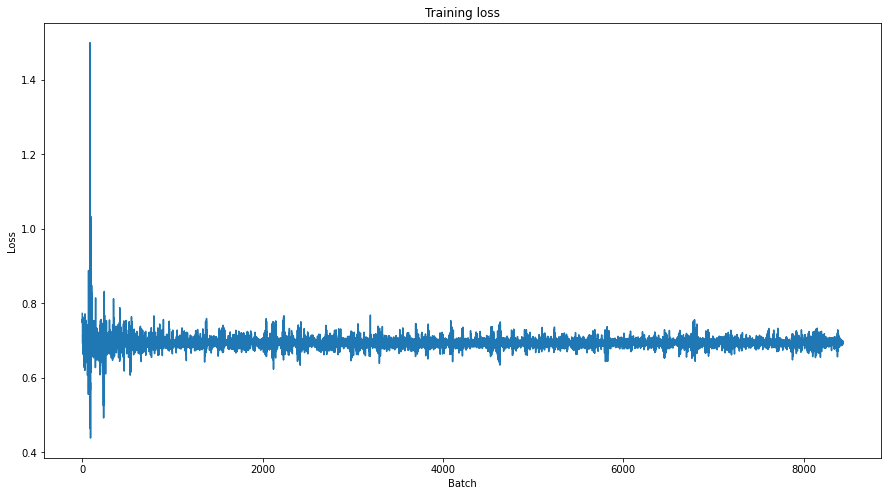

In [20]:
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()